# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec = 30*u.deg, 55*u.deg
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = 141416 #int(np.random.uniform(0,10000000))

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 18*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 0.5

# Noise
noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = 123141 #None

In [5]:
#----- Analysis parameters
# Image sampling
los_size = 1*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 10
scale_bins = 'log'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

method_setup_overwrite = True

# MCMC
nwalkers = 20
nsteps = 500
burnin = 200
mcmc_reset = True
mcmc_run = True
mcmc_Nresamp = 100

# Generate mock data

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(mock.coord.ra, mock.coord.dec, frame="icrs")
mock.map_fov    = [5, 5]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*5

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 59 , 59 , 11
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   1855.0   ,   1855.0   ] kpc ; [   4.917    ,   4.917    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.003390  /  0.098305   1/arcsec
   k min/max projected :       0.000539  /  0.015633   1/kpc
   k min/max L.o.S. (eq.) :    0.005717  /  0.028583   1/arcsec
   k min/max L.o.S. :          0.000909  /  0.004545   1/kpc
   k max Nyquist :             0.028583   1/arcsec
   k max Nyquist :             0.004545   1/kpc


In [7]:
#===== Initiate a data object and fake data
#----- Init with the mock
data = pitszi.Data(mock.get_sz_map(), mock.get_map_header())
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

#----- Define the noise properties
data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data.noise_rms = data.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)
if os.path.exists(data.output_dir+'/data_image_noise_covariance_matrix.pkl'):
    data.load_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')
else:
    data.noise_covmat = data.get_noise_covariance_from_model(Nmc=1000)
    data.save_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')

#----- Mock the data
img = data.set_image_to_mock(mock, 
                             model_seed=fluct_seed, model_no_fluctuations=False, 
                             noise_origin='model', noise_center=mock.map_center, noise_seed=noise_seed)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                           Data                             
------------------------------------------------------------


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


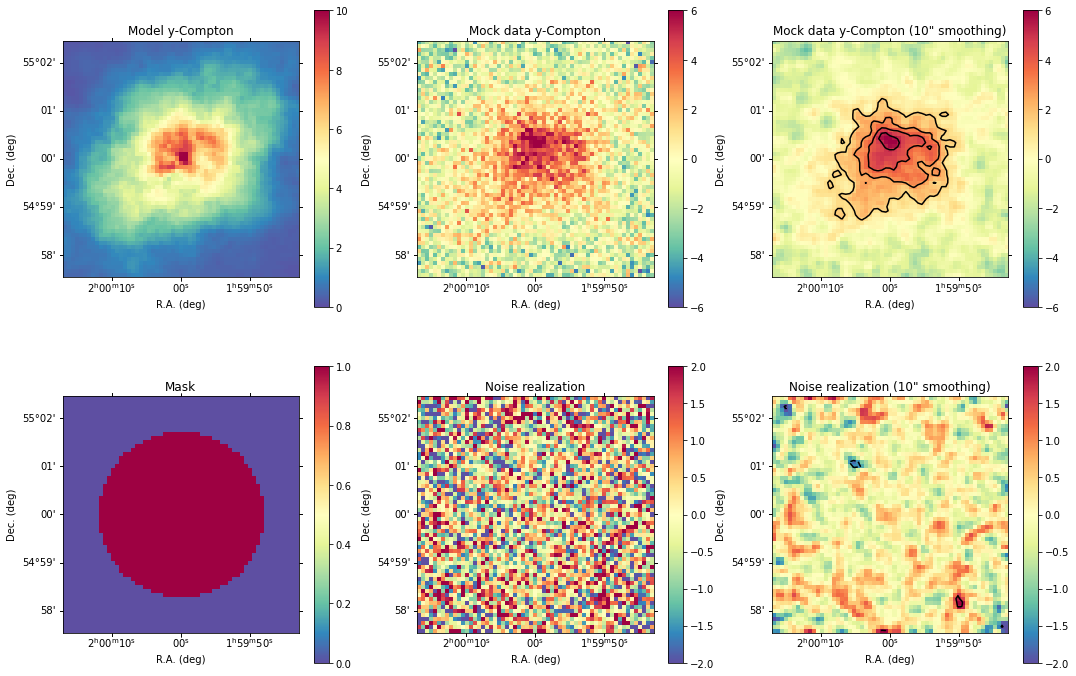

In [8]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(data.noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Build framework to constrain the data

In [9]:
model = copy.deepcopy(mock)

In [10]:
inference = pitszi.Inference(data, model, output_dir=output_dir)

inference.kbin_min   = kmin_pk
inference.kbin_max   = kmax_pk
inference.kbin_Nbin  = Nbins_pk
inference.kbin_scale = scale_bins

inference.mcmc_nwalkers = nwalkers
inference.mcmc_nsteps   = nsteps
inference.mcmc_burnin   = burnin
inference.mcmc_reset    = mcmc_reset
inference.mcmc_run      = mcmc_run
inference.mcmc_Nresamp  = mcmc_Nresamp

inference.method_use_covmat  = method_use_covmat
inference.method_parallel    = method_parallel
inference.method_data_deconv = method_data_deconv
inference.set_method_w8(apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=method_w8_smooth)

if os.path.exists(inference.output_dir+'/inference_parameters.pkl') and method_setup_overwrite == False:
    inference.load_inference(inference.output_dir+'/inference_parameters.pkl')
else:
    inference.setup()
    inference.save_inference()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                         Inference                          
------------------------------------------------------------
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [  4.   4.  12.   8.  20.  40.  60. 128. 212. 356.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----


### Check that inference can extract data, model and noise properties to be passed to fitting tools

##### Case of the radial model

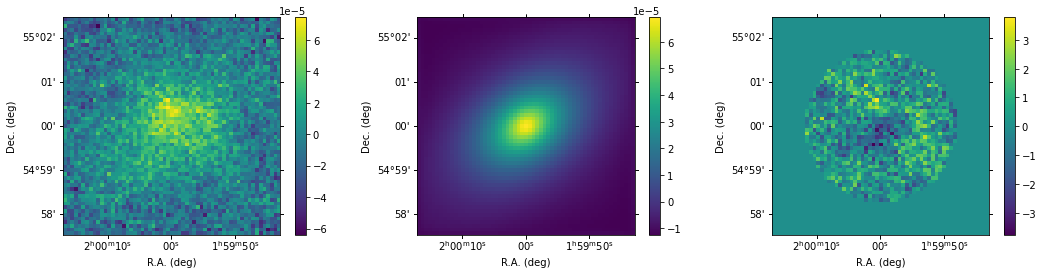

In [11]:
#inference.nuisance_ZL = 0
#inference.model.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
#                               'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
#inference.model.model_pressure_profile['P_0'] *= 1

resid = (inference.get_radial_data() - inference.get_radial_model()) / inference.get_radial_noise_statistics()[0]

plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 4))

ax = plt.subplot(1, 3, 1, projection=WCS(data.header))
plt.imshow(inference.get_radial_data())
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 2, projection=WCS(data.header))
plt.imshow(inference.get_radial_model())
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 3, projection=WCS(data.header))
plt.imshow(resid*inference.data.mask)
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

##### Case of Pk

In [12]:
unit = 'kpc'
if unit == 'arcsec':
    phys=False
if unit == 'kpc':
    phys=True

In [13]:
k2d, pk2d_data = inference.get_pk2d_data(physical=phys)
k2d, pk2d_noise, pk2d_noisecovmat = inference.get_pk2d_noise_statistics(physical=phys)
k2d, pk2d_modref, pk2d_modcovmat = inference.get_pk2d_model_statistics(physical=phys, Nmc=100)

In [14]:
k2d, pk2d_test_modbrute  = inference.get_pk2d_model_brute(physical=phys, seed=1)
k2d, pk2d_test_moddeproj = inference.get_pk2d_model_proj(physical=phys)

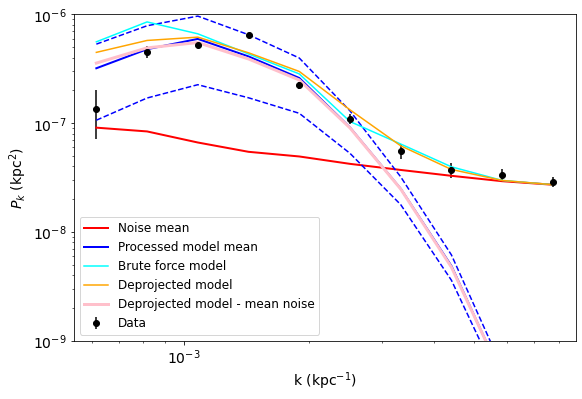

In [15]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))

plt.errorbar(k2d.to_value(unit+'-1'), pk2d_data.to_value(unit+'2'), 
             np.diag(pk2d_noisecovmat.to_value(unit+'4'))**0.5, marker='o', ls='', color='k', label='Data')
plt.plot(k2d.to_value(unit+'-1'), pk2d_noise.to_value(unit+'2'), color='red', lw=2, label='Noise mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2'), color='blue', lw=2, label='Processed model mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') + np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') - np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_modbrute.to_value(unit+'2'), color='cyan', label='Brute force model')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_moddeproj.to_value(unit+'2'), color='orange', label='Deprojected model')
plt.plot(k2d.to_value(unit+'-1'), (pk2d_test_moddeproj-pk2d_noise).to_value(unit+'2'), color='pink', lw=3, label='Deprojected model - mean noise')
plt.xscale('log')
plt.yscale('log')
plt.ylim(np.amax(pk2d_data.to_value(unit+'2'))*5e-3, np.amax(pk2d_data.to_value(unit+'2'))*1.5)
plt.ylim(1e-9,1e-6)
plt.xlabel('k ('+unit+'$^{-1}$)')
plt.ylabel(r'$P_k$ ('+unit+'$^{2}$)')
plt.legend(fontsize=12)

##### Computing time

In [16]:
start = time.time()
inference.get_radial_model()
end = time.time()
print('Computing time, radial model (s):', end - start)

start = time.time()
inference.get_pk2d_model_brute()
end = time.time()
print('Computing time, fluctuation brute (s):', end - start)

start = time.time()
inference.get_pk2d_model_proj()
end = time.time()
print('Computing time, fluctuation projection (s):', end - start)

Computing time, radial model (s): 0.03947329521179199
Computing time, fluctuation brute (s): 0.12222790718078613
Computing time, fluctuation projection (s): 0.1292870044708252


# MCMC Fitting for the profile

In [17]:
fitpar_prof = {
    #'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
    #'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
    #'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
    #'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
    #'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    #'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
    #'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]},
    #'RA': {'guess':[RA.to_value('arcmin'), 1], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-1, RA.to_value('arcmin')+1]},
    #'Dec': {'guess':[Dec.to_value('arcmin'), 1], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-1, Dec.to_value('arcmin')+1]},
    'ZL':{'guess':[0,1e-5],'unit':None},
              }

In [18]:
parlist, sampler = inference.run_mcmc_profile(fitpar_prof, show_fit_result=True)

----- Existing sampler:
      /Users/adam/Desktop/pitszi//pitszi_MCMC_Profile_sampler.h5
----- Fit parameters information -----
      - Fitted parameters:            
['M500' 'ZL']
      - Starting point mean:          
[10  0]
      - Starting point dispersion :   
[1.e+00 1.e-05]
      - Minimal starting point:       
[  1. -inf]
      - Maximal starting point:       
[100.  inf]
      - Number of dimensions:         
2
      - Parallel mode:                
False
      - Use covariance matrix?        
False
-----
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists
----- MCMC sampling -----
      - Runing 500 MCMC steps


100%|██████████| 500/500 [03:58<00:00,  2.09it/s]


param 0 (M500): 
   median   = 8.485531303045796 -0.20700182103605158 +0.19943524727146666
   best-fit = 8.469661804808284 -0.19113232279853953 +0.2153047455089787
   M500 = 8.485531303045796_{-0.20700182103605158}^{0.19943524727146666}
param 1 (ZL): 
   median   = 3.7016927404503763e-06 -4.885771955195258e-07 +4.590460529660745e-07
   best-fit = 3.7254576256632294e-06 -5.123420807323789e-07 +4.3528116775322136e-07
   ZL = 3.7016927404503763e-06_{-4.885771955195258e-07}^{4.590460529660745e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


# MCMC Fitting for the spectrum

In [19]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

In [20]:
#parlist, sampler = inference.run_mcmc_fluctuation(fitpar_pk3d, kind='projection', show_fit_result=True)
#parlist, sampler = inference.run_mcmc_fluctuation(fitpar_pk3d, kind='brute', show_fit_result=True)

# Curvefit fit

In [23]:
inference.method_use_covmat = False
plist, popt, pcov = inference.run_curvefit_profile(fitpar_prof, show_fit_result=True, set_bestfit=True)

param 0 (M500): 
   median   = 8.459978843500526 -0.19526860873592788 +0.1945473336396102
   best-fit = 8.460461818089215 -0.19575158332461662 +0.19406435905092145
   M500 = 8.459978843500526_{-0.19526860873592788}^{0.1945473336396102}
param 1 (ZL): 
   median   = 3.774798149835392e-06 -4.639124743665235e-07 +4.606379050284519e-07
   best-fit = 3.092850331093259e-06 --2.180353443756093e-07 +1.1425857237705847e-06
   ZL = 3.774798149835392e-06_{-4.639124743665235e-07}^{4.606379050284519e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


----- Running the setup -----
      - The setup was already done. It will be overwritten.
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [  4.   4.  12.   8.  20.  40.  60. 128. 212. 356.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----


In [22]:
#inference.method_use_covmat = True
#plist, popt, pcov = inference.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)